# With SentencePiece tokenizer

## Initial setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

In [3]:
bs = 512

In [4]:
data_path = Config.data_path()
lang = 'nl'
name = f'{lang}wiki_sp' # Use a different directory.
path = data_path/name
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f'{lang}_wt', f'{lang}_wt_vocab']

## Download wikipedia data

In [5]:
# from nlputils import split_wiki,get_wiki

In [6]:
# get_wiki(path, lang)

In [7]:
# path.ls()

### Split in separate files

In [8]:
dest = path/'docs_small'

In [9]:
dest.ls()[:5]

[PosixPath('/storage/nlwiki_sp/docs_small/Theophanu.txt'),
 PosixPath('/storage/nlwiki_sp/docs_small/Soepschildpad.txt'),
 PosixPath('/storage/nlwiki_sp/docs_small/Kevin van Kippersluis.txt'),
 PosixPath('/storage/nlwiki_sp/docs_small/The Seventh Cross.txt'),
 PosixPath('/storage/nlwiki_sp/docs_small/Jan Wagenaar (historicus).txt')]

## Create databunch for language model

In [10]:
# This takes about 45 minutes:
data = (TextList.from_folder(dest, processor=[OpenFileProcessor(), SPProcessor()])
       .split_by_rand_pct(0.1, seed=42)
       .label_for_lm()
       .databunch(bs=bs, num_workers=1, bptt=70))

In [11]:
data.save(f'{lang}_databunch_sp')  # Different databunch
len(data.vocab.itos),len(data.train_ds)

(30000, 1839)

In [12]:
# data.train_ds[:5]
data.vocab.itos[:1000]

['▁xxunk',
 '▁xxpad',
 '▁xxbos',
 '▁xxeos',
 '▁xxfld',
 '▁xxmaj',
 '▁xxup',
 '▁xxrep',
 '▁xxwrep',
 '<unk>',
 '▁',
 '▁de',
 '.',
 '▁van',
 ',',
 '▁in',
 '▁het',
 '▁en',
 '▁een',
 '-',
 's',
 '▁op',
 '▁zijn',
 'e',
 '▁met',
 '▁hij',
 '▁is',
 '▁te',
 '▁voor',
 '▁werd',
 'en',
 '▁"',
 '▁die',
 '"',
 '▁(',
 '▁aan',
 '▁was',
 '▁door',
 '▁als',
 '▁dat',
 '▁ook',
 '▁uit',
 '▁bij',
 '▁tot',
 ')',
 '▁om',
 '▁naar',
 '▁deze',
 "'",
 '▁er',
 '▁ze',
 '▁niet',
 '▁worden',
 '▁of',
 '▁wordt',
 'de',
 '▁maar',
 'n',
 '▁na',
 ':',
 '▁dit',
 't',
 '▁zich',
 '▁over',
 '▁onder',
 '▁eerste',
 '▁heeft',
 '▁haar',
 'a',
 '▁nog',
 '▁werden',
 '▁dan',
 '▁meer',
 '▁twee',
 '▁had',
 '▁jaar',
 '▁andere',
 'd',
 '▁al',
 'er',
 '▁waren',
 '▁hun',
 '▁tussen',
 'o',
 ').',
 '".',
 '▁kan',
 '▁waar',
 '▁tijdens',
 '▁zo',
 '▁later',
 '▁tegen',
 '▁hem',
 '▁zou',
 '▁toen',
 '",',
 '▁veel',
 '▁zij',
 '▁nieuwe',
 '▁hebben',
 '▁plaats',
 '▁jaren',
 '▁grote',
 '▁/',
 '▁geen',
 '▁echter',
 '▁tweede',
 '▁kwam',
 '),',
 'r',
 '▁

In [13]:
data.show_batch()

idx,text
0,▁xxmaj ▁byzantijn se ▁keizer ▁xxmaj ▁johannes ▁i ▁xxmaj ▁ tzi mis kes . ▁xxmaj ▁op ▁14 ▁april ▁ 972 ▁huwde ▁zij ▁op ▁ ongeveer ▁twaalfjarige ▁leeftijd ▁met ▁keizer ▁xxmaj ▁otto ▁xxup ▁ii ▁en ▁werd ▁zo doende ▁keizerin ▁van ▁het ▁xxmaj ▁heilige ▁xxmaj ▁roomse ▁xxmaj ▁rijk . ▁xxmaj ▁na ▁de ▁dood ▁van ▁xxmaj ▁otto ▁xxup ▁ii ▁werd ▁zij ▁ regentes ▁voor ▁haar ▁zoon ▁keizer ▁xxmaj ▁otto ▁xxup ▁iii . ▁xxmaj ▁otto
1,"▁om ▁te ▁slapen . ▁xxmaj ▁de ▁ s oep schildpad ▁is ▁actief ▁bij ▁een ▁water temperatuur ▁tot ▁8 ▁graden ▁xxmaj ▁celsius . ▁xxmaj ▁bij ▁een ▁lagere ▁temperatuur ▁wordt ▁de ▁ schildpad ▁in actief ▁en ▁drijft ▁tegen ▁het ▁wateroppervlak . ▁xxmaj ▁de ▁ s oep schildpad ▁is ▁de ▁enige ▁zee schildpad ▁waarvan ▁bekend ▁is ▁dat ▁weleens ▁een ▁zonne bad ▁wordt ▁genomen , ▁de ▁ schildpad ▁hij st ▁zich ▁overdag ▁op ▁het"
2,"▁in ▁de ▁illegale ▁handel , ▁heeft ▁ ertoe ▁bijgedragen ▁dat ▁de ▁ s oep schildpad ▁veel ▁minder ▁algemeen ▁is ▁dan ▁enkele ▁decennia ▁geleden . ▁xxmaj ▁de ▁ s oep schildpad ▁is ▁net ▁als ▁alle ▁zee schildpadden ▁het ▁ kwetsbaar st ▁gedur ende ▁de ▁voortplantings tijd , ▁zowel ▁aan ▁land ▁ komende ▁vrouwtjes ▁als ▁de ▁uit ▁het ▁ei ▁kruipen de ▁juveniel en ▁vallen ▁ten ▁prooi ▁aan ▁veel ▁verschillende ▁roofdieren ▁en ▁wild"
3,"▁xxmaj ▁deutsche ▁xxmaj ▁ mä del , ▁xxmaj ▁nazi organisaties ▁met ▁een ▁verplicht ▁lid maatschap ▁voor ▁kinderen ▁onder ▁de ▁twaalf ▁jaar . ▁xxmaj ▁hoewel ▁deze ▁kinderen ▁ge kleed ▁waren ▁in ▁uniformen ▁droegen ▁ze ▁niet ▁zoals ▁in ▁de ▁film , ▁ronde ▁arm banden ▁met ▁daarin ▁een ▁witte ▁cirkel ▁en ▁een ▁zwart ▁hakenkrui s . ▁xxmaj ▁deze ▁arm banden ▁werden ▁gedragen ▁door ▁volwassen ▁leden ▁van ▁de ▁xxup ▁nsdap . ▁xxbos ▁xxmaj ▁jan"
4,"▁ring erik e , ▁moeder ▁uit ▁een zelfde ▁familie ▁uit ▁xxmaj ▁bærum . ▁xxmaj ▁vader ▁kreeg ▁voorts ▁inkomsten ▁vanuit ▁een ▁van ▁de ▁grootste ▁tabak fabrieken ▁in ▁xxmaj ▁noorwegen ; ▁hij ▁was ▁daar ▁mede - eigenaar ▁van . ▁xxmaj ▁al f ▁kreeg ▁een ▁normale ▁opvoeding , ▁maar ▁gezien ▁de ▁inkomsten ▁leefde ▁hij ▁niet ▁zoals ▁vele ▁xxmaj ▁no ren ▁destijds ▁in ▁arm oe . ▁xxmaj ▁hij ▁ging ▁naar ▁school , ▁maar ▁al"


## Train language model

In [14]:
data = load_data(dest, f'{lang}_databunch_sp', bs=bs, num_workers=1)

In [15]:
# data.train_ds[:1]

In [28]:
config = dict(emb_sz=400, n_hid=1152, n_layers=3, pad_token=1, qrnn=False, bidir=False, output_p=0.1,
              hidden_p=0.15, input_p=0.25, embed_p=0.02, weight_p=0.2, tie_weights=True, out_bias=True)
learn = language_model_learner(data, AWD_LSTM, config=config, drop_mult=1.0, pretrained=False)
# learn = language_model_learner(data, AWD_LSTM, config=config, drop_mult=1.5, pretrained=False)
# learn = language_model_learner(data, AWD_LSTM, drop_mult=1.0, pretrained=False)

In [29]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


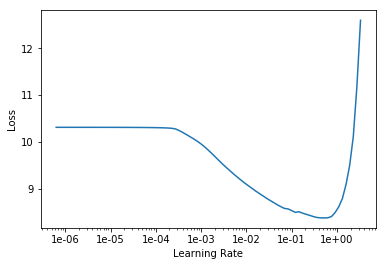

In [18]:
learn.lr_find()
learn.recorder.plot()

In [30]:
# lr = 3e-3
lr = 1e-2
# lr = 2e-2

In [31]:
# learn.fit_one_cycle(1, lr, moms=(0.8, 0.7))

In [32]:
# Previous run (lr = 5e-3)
# learn.fit_one_cycle(5, lr, moms=(0.8, 0.7))

In [ ]:
learn.fit_one_cycle(10, lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,7.298709,6.718880,0.111145,00:57
1,6.507833,5.989216,0.163142,00:58
2,5.954316,5.516237,0.195117,00:58
3,5.499518,5.307798,0.205712,00:58
4,5.138740,5.080887,0.224789,00:58
5,4.841452,4.930434,0.237464,00:58
6,4.613782,4.850431,0.243172,00:58
7,4.420297,4.802327,0.247349,00:58
8,4.259699,4.783391,0.249282,00:58


In [23]:
# learn.fit_one_cycle(1, lr, moms=(0.8, 0.7))

In [24]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
# learn.to_fp32().save(mdl_path/lm_fns[0], with_opt=False)
learn.save(mdl_path/lm_fns[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns[1] + '.pkl'))

In [25]:
TEXT = '''Het beleg van Utrecht

Het beleg van Utrecht'''
N_WORDS = 200
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.85) for _ in range(N_SENTENCES)))

Het beleg van Utrecht

Het beleg van Utrecht ▁( ver s loper ▁van ▁24 3% ▁tijdens ▁de ▁xxmaj ▁eerste ▁xxmaj ▁wereldoorlog ) ▁is ▁een ▁xxmaj ▁pruisische ▁kwestie . ▁xxmaj ▁de ▁eerste ▁universiteiten ▁zijn ▁xxmaj ▁ alexandr o ▁xxmaj ▁leo , ▁xxmaj ▁maar rah ark ▁xxmaj ▁hill , ▁xxmaj ▁ cul line ▁xxmaj ▁embrun , ▁xxmaj ▁cle no to ▁xxmaj ▁ ł e ▁strandde , ▁xxmaj ▁wa ino , ▁xxmaj ▁ gru an , ▁xxmaj ▁ s el laan , ▁xxmaj ▁ ne ink , ▁xxmaj ▁mo bi creation n , ▁xxmaj ▁bou overschot , ▁xxmaj ▁ poel a , ▁xxmaj ▁bot buck , ▁xxmaj ▁ oyos , ▁xxmaj ▁ o tian es , ▁xxmaj ▁ wei bury , ▁xxmaj ▁ el ble e , ▁xxmaj ▁mexico , ▁xxmaj ▁anorthosi , ▁xxmaj ▁ pennsylvania , ▁xxmaj ▁ beke da , ▁xxmaj ▁ ux ille , ▁xxmaj ▁ sara za x , ▁xxmaj ▁wood veld , ▁xxmaj ▁cam k ana heim , ▁xxmaj ▁sint ▁xxmaj ▁londen ▁en ▁xxmaj ▁ro rand ▁xxmaj ▁ ar o oor mb en . ▁xxmaj ▁in ▁xxmaj ▁berlijn ▁wordt ▁de ▁xxmaj ▁turkse ▁ regulering ▁tussen ▁de ▁xxmaj ▁efik , ▁de ▁xxmaj ▁joden ▁en ▁de ▁xxmaj ▁italiaanse ▁xxmaj ▁andes ▁nog ▁gescheiden ▁v

In [26]:
# learn = language_model_learner(data, AWD_LSTM, drop_mult=1., 
#                                   path = path, 
#                                   pretrained_fnames=lm_fns)
learn.export()

In [27]:
TEXT = '''Jan Wolkers

Jan Wolkers'''
N_WORDS = 500
N_SENTENCES = 1

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.65) for _ in range(N_SENTENCES)))

Jan Wolkers

Jan Wolkers , ▁heer ▁van ▁xxmaj ▁ stad ▁of ▁xxmaj ▁ eg mont ▁van ▁xxmaj ▁ eg mont ▁van ▁der ▁xxmaj ▁congregati e ▁( rotterdam , ▁13 ▁maart ▁11 49 ▁ - ▁xxmaj ▁paramaribo , ▁27 ▁oktober ▁1917 ) ▁was ▁een ▁xxmaj ▁ bulgaars ▁ diskjockey , ▁die ▁bekend ▁was ▁als ▁xxmaj ▁ fellow s ▁xxmaj ▁centrum . ▁xxmaj ▁hij ▁groeide ▁op ▁in ▁xxmaj ▁ missouri , ▁xxmaj ▁italië . ▁xxmaj ▁hij ▁trouwde ▁met ▁xxmaj ▁frank ▁xxmaj ▁ z elaer ▁en ▁xxmaj ▁anna ▁xxmaj ▁ aya nne , ▁die ▁hij ▁was . ▁xxmaj ▁in ▁2008 ▁was ▁hij ▁deel ▁van ▁het ▁xxmaj ▁nederlands ▁xxmaj ▁parlement . ▁xxmaj ▁in ▁zijn ▁studie ▁begon ▁hij ▁in ▁xxmaj ▁de n ▁xxmaj ▁haag . ▁xxmaj ▁hij ▁stierf ▁in ▁1921 . ▁xxmaj ▁in ▁1768 ▁werd ▁hij ▁lid ▁van ▁xxmaj ▁ kruisweg . ▁xxmaj ▁zijn ▁vader ▁was ▁xxmaj ▁anna ▁xxmaj ▁ s ig s ▁en ▁xxmaj ▁ agnese ▁xxmaj ▁ gen s s á . ▁xxmaj ▁hij ▁trad ▁op ▁als ▁de ▁vrouw ▁van ▁xxmaj ▁anna ▁van ▁xxmaj ▁ eg mont . ▁xxmaj ▁hij ▁werd ▁geboren ▁in ▁xxmaj ▁ t pen au la , ▁xxmaj ▁ petersburg ▁in ▁xxmaj ▁amsterdam . ▁xx